# IFN646 All Models

In [1]:
import pandas as pd
import numpy as np
import glob

from io import StringIO

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import plot_confusion_matrix


import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filenames = glob.glob('IFN646_project/' + "*.csv")

dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))
    
sleepwake = pd.concat(dfs, ignore_index=True)

In [3]:
sleepwake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49312 entries, 0 to 49311
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   timestamp                  49312 non-null  object 
 1   Actiwatch activity counts  49100 non-null  float64
 2   Actiware classification    48919 non-null  float64
 3   Apple Watch ENMO           49278 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.5+ MB


In [4]:
sleepwake.describe()

,Actiwatch activity counts,Actiware classification,Apple Watch ENMO
count,49100.000000,48919.000000,49278.000000
mean,4.110468,0.079642,0.006621
std,24.561319,0.270741,0.029242
min,0.000000,0.000000,0.000505
25%,0.000000,0.000000,0.001897
50%,0.000000,0.000000,0.003029
75%,0.000000,0.000000,0.004746
max,880.000000,1.000000,3.342039


In [5]:
sleepwake.head()

,timestamp,Actiwatch activity counts,Actiware classification,Apple Watch ENMO
0,06/01/2000 22:11:00,NaN,NaN,0.047328
1,06/01/2000 22:11:15,91.0,NaN,0.049485
2,06/01/2000 22:11:30,62.0,NaN,0.047339
3,06/01/2000 22:11:45,58.0,NaN,0.069403
4,06/01/2000 22:12:00,154.0,NaN,1.066049


In [6]:
#change timestamp data type
sleepwake['timestamp'] = pd.to_datetime(sleepwake['timestamp'])

In [7]:
sleepwake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49312 entries, 0 to 49311
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   timestamp                  49312 non-null  datetime64[ns]
 1   Actiwatch activity counts  49100 non-null  float64       
 2   Actiware classification    48919 non-null  float64       
 3   Apple Watch ENMO           49278 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.5 MB


In [8]:
sleepwake.describe()

,Actiwatch activity counts,Actiware classification,Apple Watch ENMO
count,49100.000000,48919.000000,49278.000000
mean,4.110468,0.079642,0.006621
std,24.561319,0.270741,0.029242
min,0.000000,0.000000,0.000505
25%,0.000000,0.000000,0.001897
50%,0.000000,0.000000,0.003029
75%,0.000000,0.000000,0.004746
max,880.000000,1.000000,3.342039


In [9]:
# rename column name
sleepwake.rename(columns = {'Actiwatch activity counts' : 'actiwatch_counts',
                           'Actiware classification' : 'actiware_class',
                           'Apple Watch ENMO' : 'Apple_ENMO'}, inplace = True)
sleepwake.head()

,timestamp,actiwatch_counts,actiware_class,Apple_ENMO
0,2000-06-01 22:11:00,NaN,NaN,0.047328
1,2000-06-01 22:11:15,91.0,NaN,0.049485
2,2000-06-01 22:11:30,62.0,NaN,0.047339
3,2000-06-01 22:11:45,58.0,NaN,0.069403
4,2000-06-01 22:12:00,154.0,NaN,1.066049


In [10]:
sleepwake = sleepwake[sleepwake['actiware_class'].notna()]
sleepwake = sleepwake[sleepwake['actiwatch_counts'].notna()]
sleepwake = sleepwake[sleepwake['Apple_ENMO'].notna()]

In [11]:
sleepwake.head()

,timestamp,actiwatch_counts,actiware_class,Apple_ENMO
5,2000-06-01 22:12:15,164.0,1.0,0.503060
6,2000-06-01 22:12:30,159.0,1.0,0.117267
7,2000-06-01 22:12:45,94.0,1.0,0.075325
8,2000-06-01 22:13:00,0.0,1.0,0.003893
9,2000-06-01 22:13:15,6.0,1.0,0.006534


In [12]:
sleepwake.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48909 entries, 5 to 49300
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   timestamp         48909 non-null  datetime64[ns]
 1   actiwatch_counts  48909 non-null  float64       
 2   actiware_class    48909 non-null  float64       
 3   Apple_ENMO        48909 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.9 MB


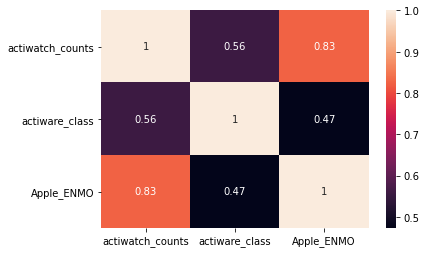

In [13]:
corrMatrix = sleepwake.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

## Exploratory Analysis

In [14]:
# output = actiware_class
# input = actiwatch_counts / Apple_ENMO

(0.0, 0.05)

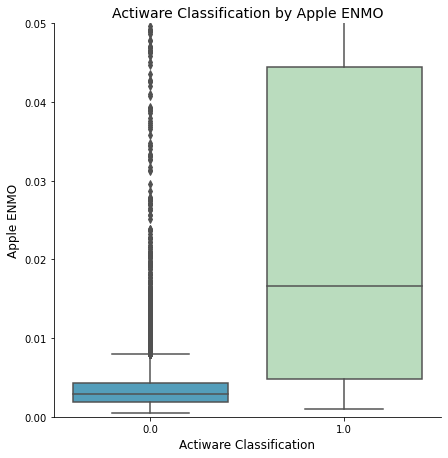

In [15]:
sn.catplot(x="actiware_class", y="Apple_ENMO", kind="box", data=sleepwake
          ,palette="GnBu_r", height=6, aspect=9/9)
plt.title("Actiware Classification by Apple ENMO", fontsize=14)
plt.xlabel("Actiware Classification", fontsize=12)
plt.ylabel("Apple ENMO", fontsize=12) 
plt.ylim(0.0,0.05)

(0.0, 70.0)

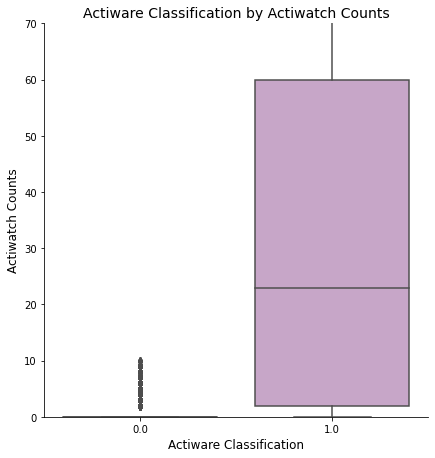

In [16]:
sn.catplot(x="actiware_class", y="actiwatch_counts", kind="box", data=sleepwake
          ,palette="PuRd_r", height=6, aspect=9/9)
plt.title("Actiware Classification by Actiwatch Counts", fontsize=14)
plt.xlabel("Actiware Classification", fontsize=12)
plt.ylabel("Actiwatch Counts", fontsize=12) 
plt.ylim(0.0,70)

### Train Test Split

In [17]:
x = sleepwake[['actiwatch_counts', 'Apple_ENMO']]
y = sleepwake['actiware_class']

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3, random_state=10)

### Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier(n_estimators = 100)
randomforest_model = randomforest.fit(x_train[['Apple_ENMO']], y_train)
y_predicted_r = randomforest.predict(x_test[['Apple_ENMO']])

randomforest_ac = RandomForestClassifier(n_estimators = 100)
randomforest_model_ac = randomforest_ac.fit(x_train[['actiwatch_counts']], y_train)
y_predicted_r_ac = randomforest_ac.predict(x_test[['actiwatch_counts']])

In [20]:
print("Train accuracy:", randomforest.score(x_train[['Apple_ENMO']], y_train))

Train accuracy: 0.9821824979553686


In [21]:
print("Test accuracy:", randomforest.score(x_test[['Apple_ENMO']], y_test))

Test accuracy: 0.9421386219586997


In [22]:
print("Train accuracy:", randomforest_ac.score(x_train[['actiwatch_counts']], y_train))

Train accuracy: 0.9740039724266853


In [23]:
print("Test accuracy:", randomforest_ac.score(x_test[['actiwatch_counts']], y_test))

Test accuracy: 0.9750562257207115


In [24]:
# k-fold cross validation to evaluate the performance of the model
from sklearn.model_selection import cross_val_score
accuracy = cross_val_score(estimator = randomforest, X = x_train, y = y_train, cv =10)
accuracy.mean()

0.9619991873964195

In [25]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_predicted_r)
cnf_matrix

array([[13170,   368],
       [  481,   654]])

In [26]:
cnf_matrix_ac = metrics.confusion_matrix(y_test, y_predicted_r_ac)
cnf_matrix_ac

array([[13513,    25],
       [  341,   794]])

In [27]:
from sklearn.metrics import plot_confusion_matrix

In [28]:
def eval_model(model, x_train, y_train, x_test, y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = plot_confusion_matrix(model, x_train, y_train, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(x_train)
    conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == y_train)/len(y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = plot_confusion_matrix(model, x_test, y_test, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(x_test)
    conf.ax_.set_title('Testing Set Performance: ' + str(sum(pred == y_test)/len(y_test)));


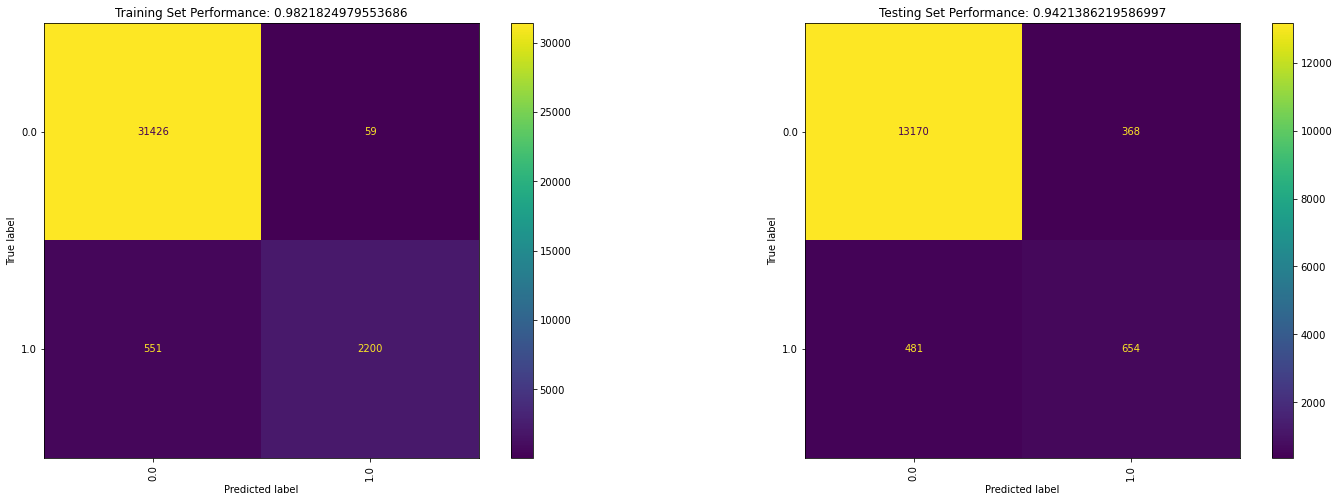

In [29]:
eval_model(randomforest, x_train[['Apple_ENMO']], y_train, x_test[['Apple_ENMO']], y_test)

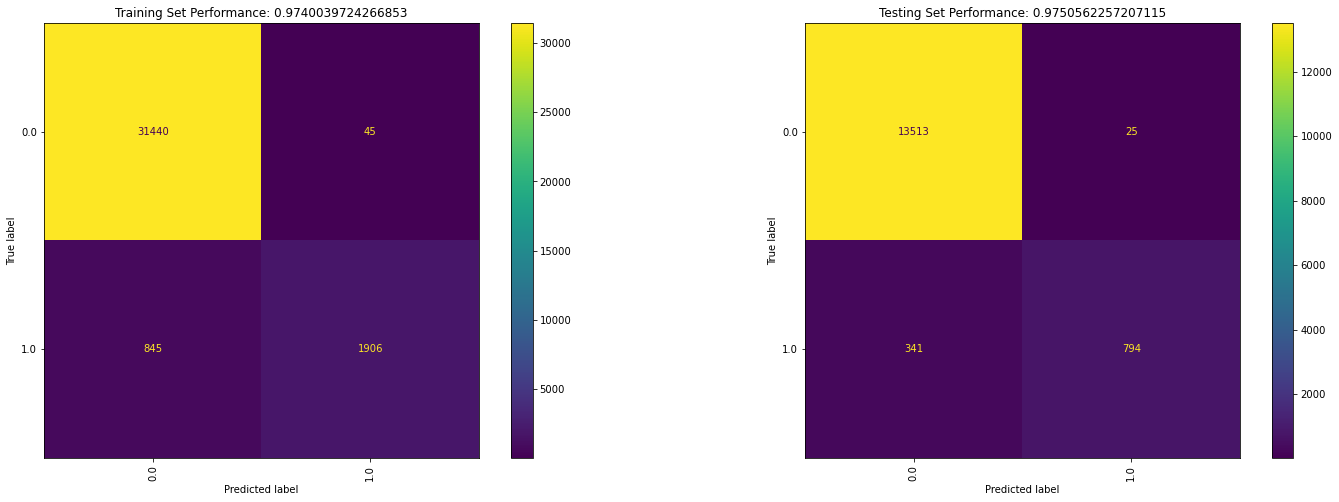

In [30]:
eval_model(randomforest_ac, x_train[['actiwatch_counts']], y_train,
           x_test[['actiwatch_counts']], y_test)

Text(0.5, 1.0, 'DET Curve')

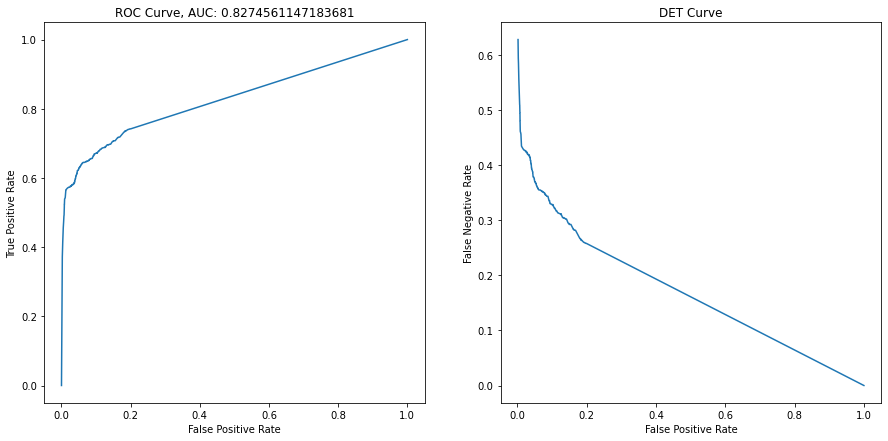

In [31]:
from sklearn.metrics import roc_curve, det_curve, roc_auc_score, auc

scores = randomforest.predict_proba(x_test[['Apple_ENMO']])

fig = plt.figure(figsize=[15, 7])
fpr, tpr, thresholds = roc_curve(y_test, scores[:, 1])
auc_score = roc_auc_score(y_test, scores[:, 1])
ax = fig.add_subplot(1, 2, 1)
ax.plot(fpr, tpr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve, AUC: ' + str(auc_score))

fpr, fnr, thresholds = det_curve(y_test, scores[:, 1])
ax = fig.add_subplot(1, 2, 2)
ax.plot(fpr, fnr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('False Negative Rate')
ax.set_title('DET Curve')

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
print(classification_report(y_test, randomforest.predict(x_test[['Apple_ENMO']])))

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     13538
         1.0       0.64      0.58      0.61      1135

    accuracy                           0.94     14673
   macro avg       0.80      0.77      0.79     14673
weighted avg       0.94      0.94      0.94     14673



In [33]:
print(classification_report(y_test, randomforest_ac.predict(x_test[['actiwatch_counts']])))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     13538
         1.0       0.97      0.70      0.81      1135

    accuracy                           0.98     14673
   macro avg       0.97      0.85      0.90     14673
weighted avg       0.97      0.98      0.97     14673



In [34]:
from sklearn.model_selection import cross_val_score
print(np.mean(cross_val_score(randomforest, x_train[['Apple_ENMO']], y_train, cv=10)))

0.9401216362785009


In [35]:
print(np.mean(cross_val_score(randomforest_ac, x_train[['actiwatch_counts']], y_train, cv=10)))

0.9738289088928388


# Logistic Regression

In [36]:
x_train

,actiwatch_counts,Apple_ENMO
13033,0.0,0.001437
8364,0.0,0.004419
45978,0.0,0.003594
4183,0.0,0.003921
44483,0.0,0.002433
...,...,...
40387,0.0,0.007883
28243,0.0,0.001510
29438,0.0,0.001973
40389,0.0,0.007658


In [37]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(x_train[['Apple_ENMO']], y_train)
y_pred = logreg.predict(x_test[['Apple_ENMO']])

logreg_2 = LogisticRegression()
logreg_2.fit(x_train[['actiwatch_counts']], y_train)
y_pred_2 = logreg.predict(x_test[['actiwatch_counts']])


In [38]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print("Confusion Matrix for Apple Watch ENMO")
print(cnf_matrix)

Confusion Matrix for Apple Watch ENMO
[[13538     0]
 [  987   148]]


In [39]:
cnf_matrix2 = metrics.confusion_matrix(y_test, y_pred_2)
print("Confusion Matrix for Actiwatch activity counts")
print(cnf_matrix2)

Confusion Matrix for Actiwatch activity counts
[[13292   246]
 [  282   853]]


In [40]:
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = plot_confusion_matrix(model, X_train, Y_train, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = plot_confusion_matrix(model, X_test, Y_test, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Testing Set Performance: ' + str(sum(pred == Y_test)/len(Y_test)));


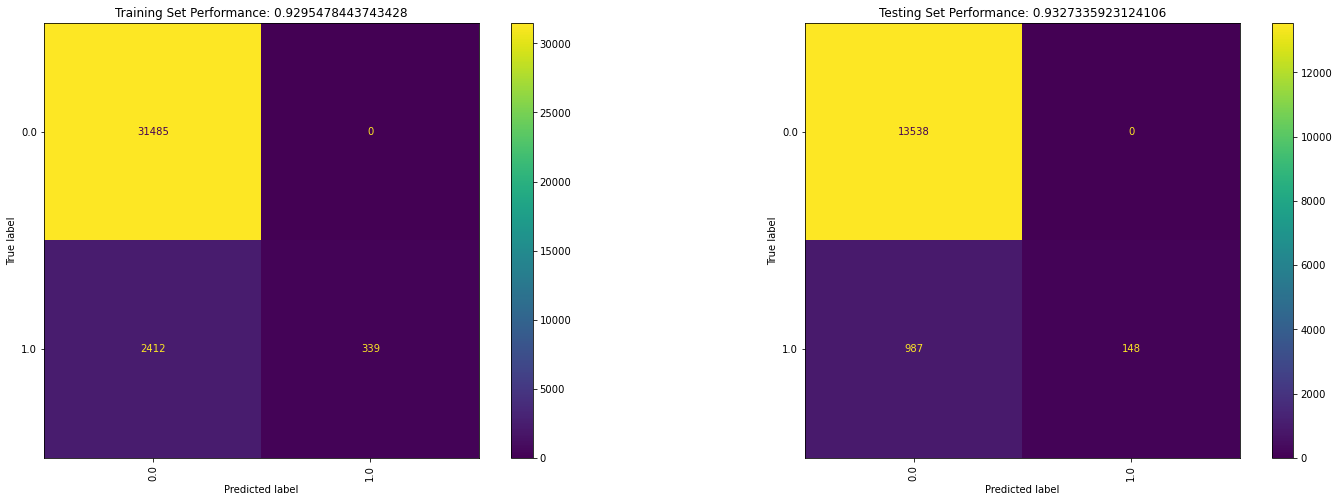

In [41]:
eval_model(logreg, x_train[['Apple_ENMO']], y_train, x_test[['Apple_ENMO']], y_test)

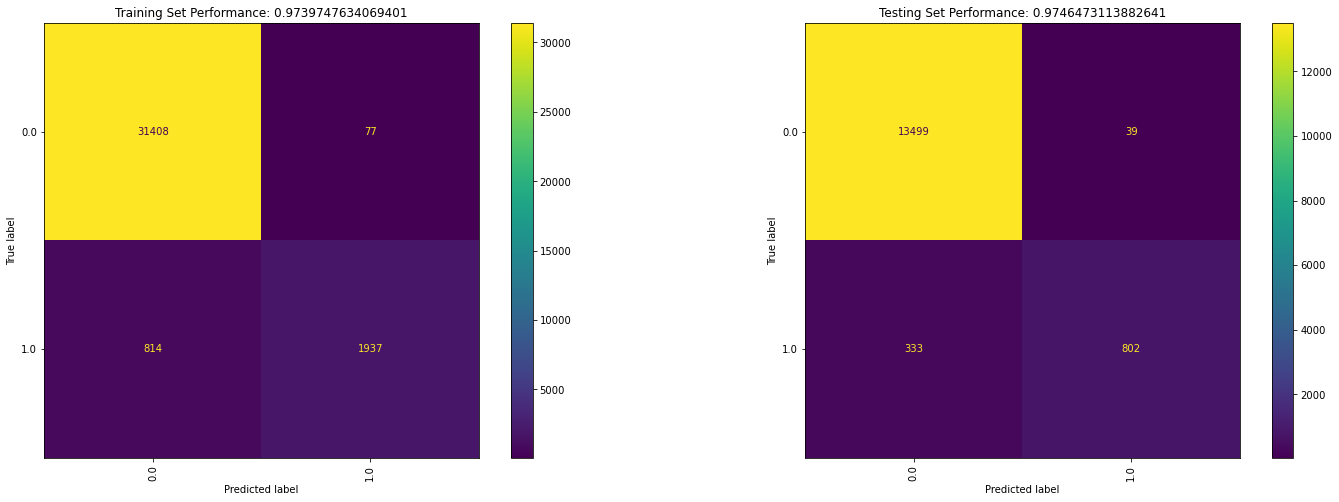

In [42]:
eval_model(logreg_2, x_train[['actiwatch_counts']], y_train, x_test[['actiwatch_counts']], y_test)

Text(0.5, 1.0, 'DET Curve')

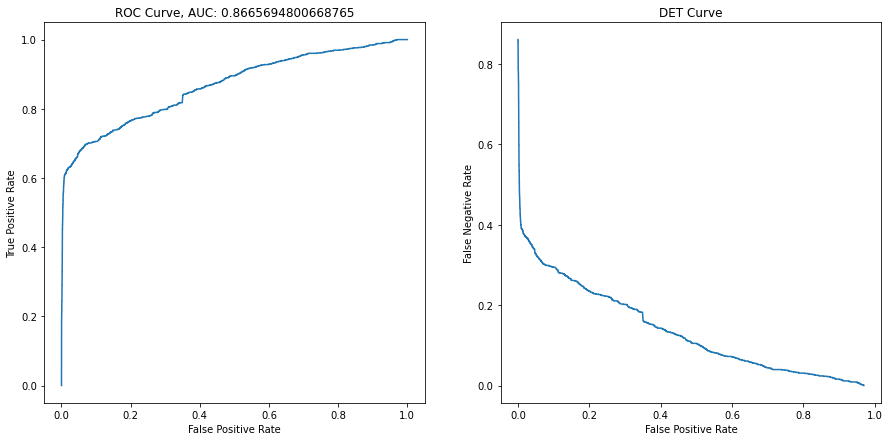

In [43]:
from sklearn.metrics import roc_curve, det_curve, roc_auc_score, auc

scores = logreg.predict_proba(x_test[['Apple_ENMO']])

fig = plt.figure(figsize=[15, 7])
fpr, tpr, thresholds = roc_curve(y_test, scores[:, 1])
auc_score = roc_auc_score(y_test, scores[:, 1])
ax = fig.add_subplot(1, 2, 1)
ax.plot(fpr, tpr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve, AUC: ' + str(auc_score))

fpr, fnr, thresholds = det_curve(y_test, scores[:, 1])
ax = fig.add_subplot(1, 2, 2)
ax.plot(fpr, fnr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('False Negative Rate')
ax.set_title('DET Curve')

In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
print(classification_report(y_test, logreg.predict(x_test[['Apple_ENMO']])))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     13538
         1.0       1.00      0.13      0.23      1135

    accuracy                           0.93     14673
   macro avg       0.97      0.57      0.60     14673
weighted avg       0.94      0.93      0.91     14673



In [45]:
# k-fold cross validation to evaluate the performance of the model
from sklearn.linear_model import LogisticRegressionCV
clflogreg = LogisticRegressionCV(cv=10, random_state=0).fit(x[['Apple_ENMO']],y)
clflogreg.predict(x[['Apple_ENMO']])
clflogreg.predict_proba(x[['Apple_ENMO']]).shape
clflogreg.score(x[['Apple_ENMO']],y)

0.955631887791613

In [46]:
clflogreg = LogisticRegressionCV(cv=10, random_state=0).fit(x[['Apple_ENMO']],y)
clflogreg.predict(x[['Apple_ENMO']])
clflogreg.predict_proba(x[['Apple_ENMO']]).shape
clflogreg.score(x[['Apple_ENMO']],y)

0.955631887791613

# Neural Network

In [47]:
rs = 200
model_1 = MLPClassifier(random_state=rs)
model_1.fit(x_train, y_train)

print("Train accuracy:", model_1.score(x_train, y_train))
print("Test accuracy:", model_1.score(x_test, y_test))

y_pred = model_1.predict(x_test)

print(classification_report(y_test, y_pred))

print(model_1)

Train accuracy: 0.9740915994859213
Test accuracy: 0.9747154637770054
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     13538
         1.0       0.95      0.71      0.81      1135

    accuracy                           0.97     14673
   macro avg       0.96      0.85      0.90     14673
weighted avg       0.97      0.97      0.97     14673

MLPClassifier(random_state=200)


In [48]:
model_2 = MLPClassifier(max_iter=10000, random_state=rs)
model_2.fit(x_train, y_train)

print("Train accuracy:", model_2.score(x_train, y_train))
print("Test accuracy:", model_2.score(x_test, y_test))

y_pred = model_2.predict(x_test)
print(classification_report(y_test, y_pred))

print(model_2)

Train accuracy: 0.9740915994859213
Test accuracy: 0.9747154637770054
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     13538
         1.0       0.95      0.71      0.81      1135

    accuracy                           0.97     14673
   macro avg       0.96      0.85      0.90     14673
weighted avg       0.97      0.97      0.97     14673

MLPClassifier(max_iter=10000, random_state=200)


In [49]:
model_3 = MLPClassifier(max_iter=10000, random_state=rs)
model_3.fit(x_train[['Apple_ENMO']], y_train)

print("Train accuracy:", model_3.score(x_train[['Apple_ENMO']], y_train))
print("Test accuracy:", model_3.score(x_test[['Apple_ENMO']], y_test))

y_pred = model_3.predict(x_test[['Apple_ENMO']])
print(classification_report(y_test, y_pred))

print(model_3)

Train accuracy: 0.9591657903960743
Test accuracy: 0.9614257479724664
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     13538
         1.0       0.89      0.57      0.70      1135

    accuracy                           0.96     14673
   macro avg       0.93      0.78      0.84     14673
weighted avg       0.96      0.96      0.96     14673

MLPClassifier(max_iter=10000, random_state=200)


In [50]:
params = {'hidden_layer_sizes': [(x,) for x in range(5, 86, 20)]}

cv_1 = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs),return_train_score=True, cv=10, n_jobs=-1)
cv_1.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=MLPClassifier(random_state=200), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(5,), (25,), (45,), (65,),
                                                (85,)]},
             return_train_score=True)

In [51]:
result_set = cv_1.cv_results_
print(result_set)

{'mean_fit_time': array([2.59756346, 2.67809241, 4.67763107, 2.95614893, 3.65861812]), 'std_fit_time': array([0.0374152 , 0.32177366, 1.52591264, 0.28674722, 0.55038001]), 'mean_score_time': array([0.0039721 , 0.00496416, 0.00741222, 0.00641499, 0.00430541]), 'std_score_time': array([0.00031504, 0.00113191, 0.00397532, 0.00429237, 0.00129154]), 'param_hidden_layer_sizes': masked_array(data=[(5,), (25,), (45,), (65,), (85,)],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'hidden_layer_sizes': (5,)}, {'hidden_layer_sizes': (25,)}, {'hidden_layer_sizes': (45,)}, {'hidden_layer_sizes': (65,)}, {'hidden_layer_sizes': (85,)}], 'split0_test_score': array([0.97517523, 0.97517523, 0.97488318, 0.97517523, 0.97488318]), 'split1_test_score': array([0.97225467, 0.97225467, 0.97225467, 0.97225467, 0.97196262]), 'split2_test_score': array([0.97400701, 0.97400701, 0.97371495, 0.97400701, 0.97400701]), 'split3_test_score': array([0.

Total number of models:  5


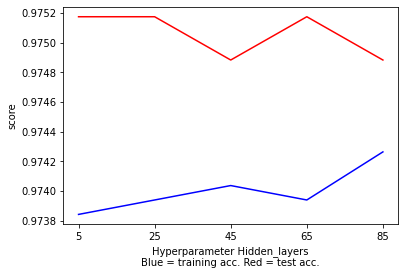

In [52]:
train_result = result_set['split0_train_score']
test_result = result_set['split0_test_score']
print("Total number of models: ", len(test_result))
# plot hidden layers hyperparameter values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
plt.xlabel('Hyperparameter Hidden_layers\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),range(5, 86, 20))
plt.ylabel('score')
plt.show()

In [53]:
print("Train accuracy:", cv_1.score(x_train, y_train))
print("Test accuracy:", cv_1.score(x_test, y_test))

y_pred = cv_1.predict(x_test)
print(classification_report(y_test, y_pred))

print(cv_1.best_params_)

Train accuracy: 0.9740915994859213
Test accuracy: 0.9747154637770054
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     13538
         1.0       0.95      0.71      0.81      1135

    accuracy                           0.97     14673
   macro avg       0.96      0.85      0.90     14673
weighted avg       0.97      0.97      0.97     14673

{'hidden_layer_sizes': (25,)}


In [54]:
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv_3 = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv_3.fit(x_train, y_train)

print("Train accuracy:", cv_3.score(x_train, y_train))
print("Test accuracy:", cv_3.score(x_test, y_test))

y_pred = cv_3.predict(x_test)
print(classification_report(y_test, y_pred))

print(cv_3.best_params_)

Train accuracy: 0.9739747634069401
Test accuracy: 0.9746473113882641
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     13538
         1.0       0.95      0.71      0.81      1135

    accuracy                           0.97     14673
   macro avg       0.96      0.85      0.90     14673
weighted avg       0.97      0.97      0.97     14673

{'alpha': 0.001, 'hidden_layer_sizes': (3,)}


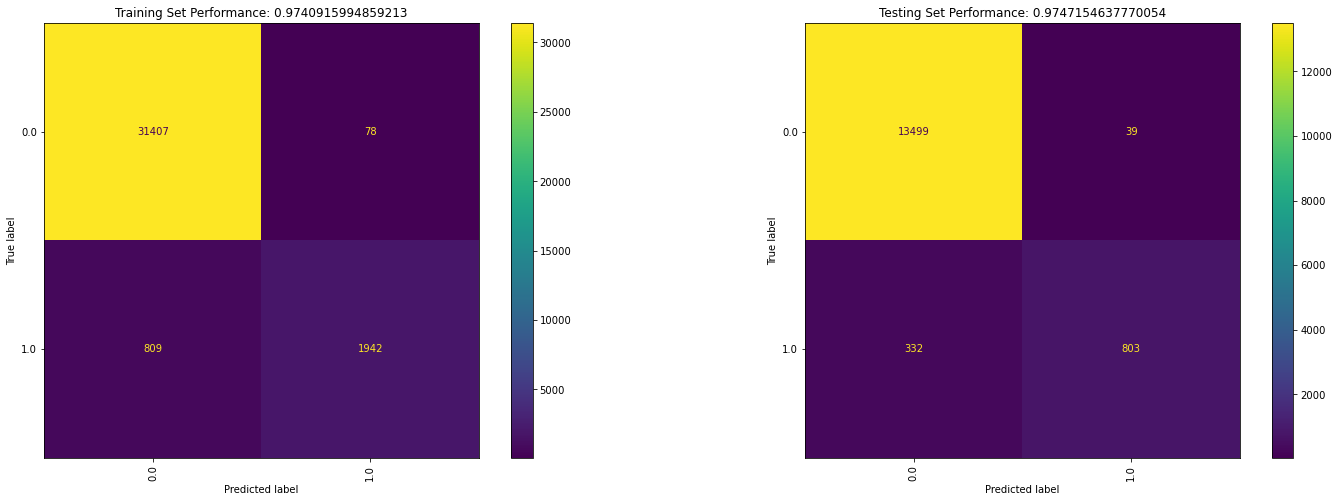

In [55]:
eval_model(cv_1, x_train, y_train, x_test, y_test)

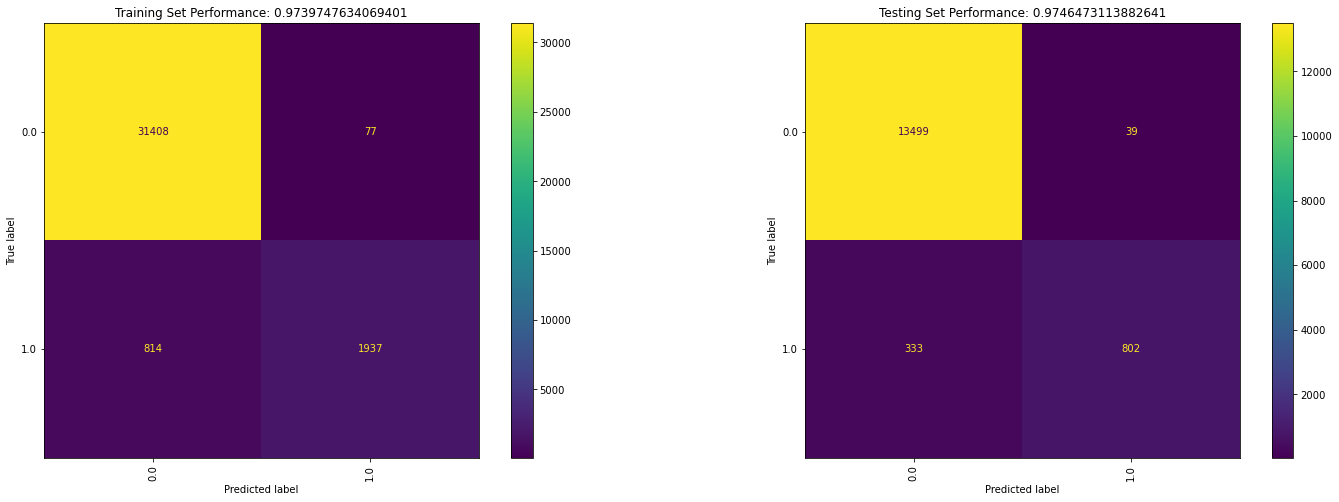

In [56]:
eval_model(cv_3, x_train, y_train, x_test, y_test)

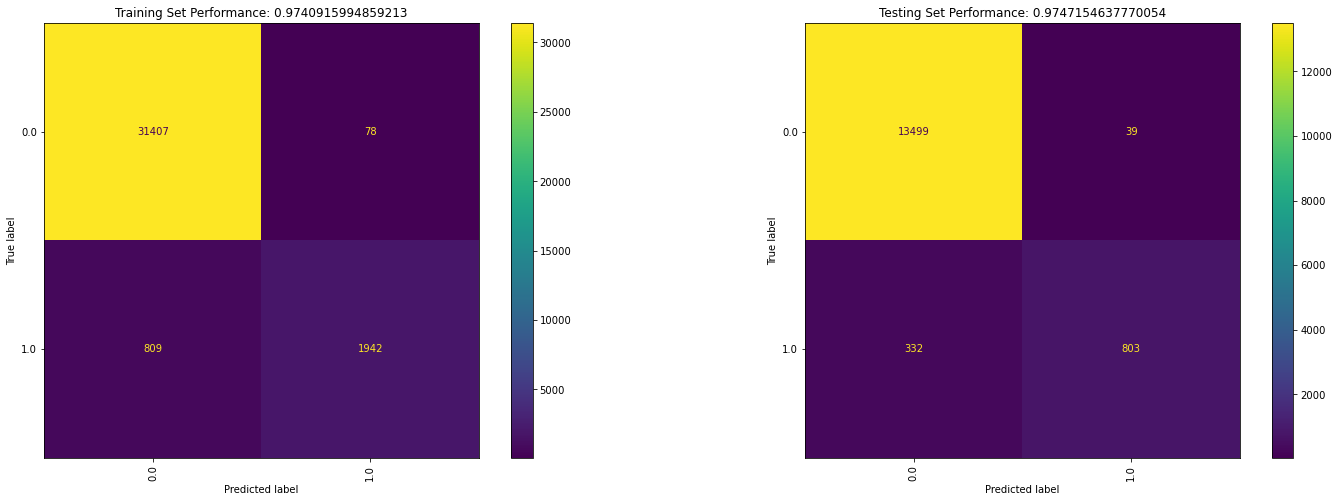

In [57]:
eval_model(model_1, x_train, y_train, x_test, y_test)

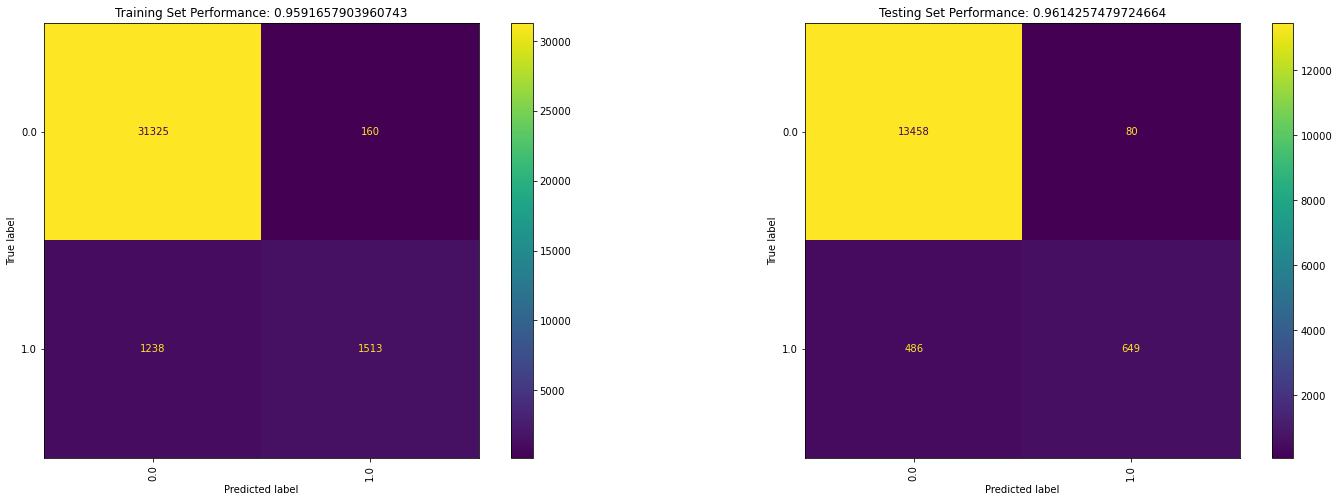

In [58]:
eval_model(model_3, x_train[['Apple_ENMO']], y_train, x_test[['Apple_ENMO']], y_test)

Text(0.5, 1.0, 'DET Curve')

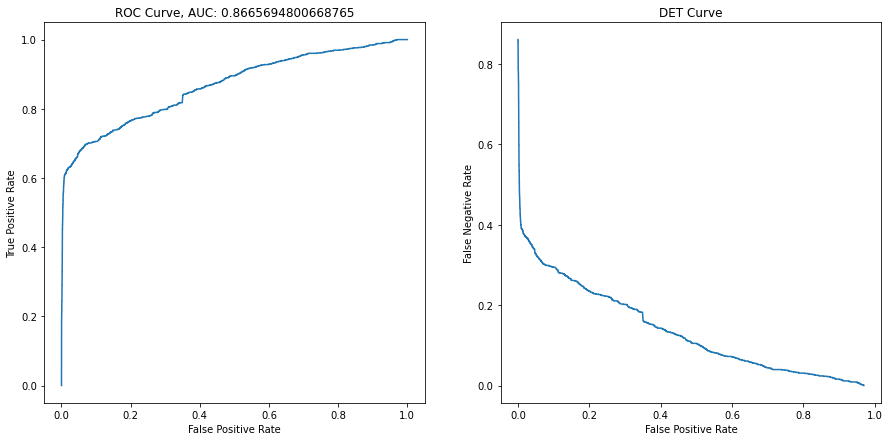

In [59]:
from sklearn.metrics import roc_curve, det_curve, roc_auc_score, auc

scores = model_3.predict_proba(x_test[['Apple_ENMO']])

fig = plt.figure(figsize=[15, 7])
fpr, tpr, thresholds = roc_curve(y_test, scores[:, 1])
auc_score = roc_auc_score(y_test, scores[:, 1])
ax = fig.add_subplot(1, 2, 1)
ax.plot(fpr, tpr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve, AUC: ' + str(auc_score))

fpr, fnr, thresholds = det_curve(y_test, scores[:, 1])
ax = fig.add_subplot(1, 2, 2)
ax.plot(fpr, fnr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('False Negative Rate')
ax.set_title('DET Curve')

# Comparing three model

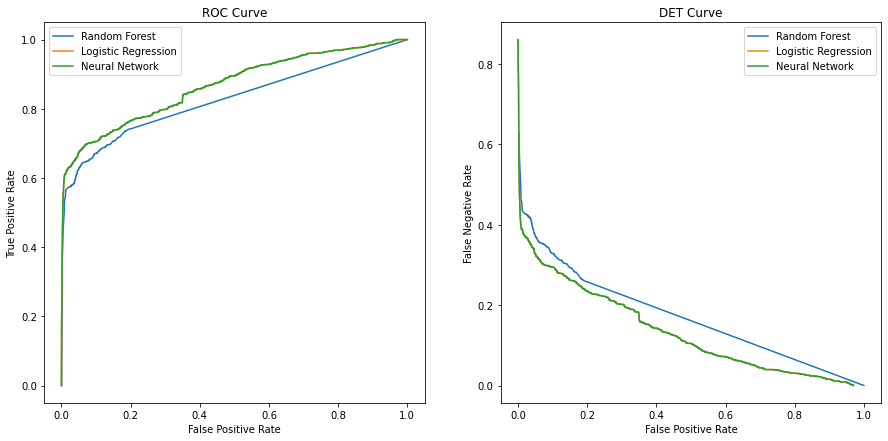

In [60]:
# random forest

# logistic regression

# neural network
rf_scores = randomforest_model.predict_proba(x_test[['Apple_ENMO']])
lg_scores = logreg.predict_proba(x_test[['Apple_ENMO']])
nn_scores = model_3.predict_proba(x_test[['Apple_ENMO']])

fig = plt.figure(figsize=[15, 7])
ax = fig.add_subplot(1, 2, 1)
fpr, tpr, thresholds = roc_curve(y_test, rf_scores[:, 1])
ax.plot(fpr, tpr)
fpr, tpr, thresholds = roc_curve(y_test, lg_scores[:, 1])
ax.plot(fpr, tpr)
fpr, tpr, thresholds = roc_curve(y_test, nn_scores[:, 1])
ax.plot(fpr, tpr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend(['Random Forest', 'Logistic Regression', 'Neural Network', 'NN_CV'])

ax = fig.add_subplot(1, 2, 2)
fpr, fnr, thresholds = det_curve(y_test, rf_scores[:, 1])
ax.plot(fpr, fnr)
fpr, fnr, thresholds = det_curve(y_test, lg_scores[:, 1])
ax.plot(fpr, fnr)
fpr, fnr, thresholds = det_curve(y_test, nn_scores[:, 1])
ax.plot(fpr, fnr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('False Negative Rate')
ax.set_title('DET Curve')
ax.legend(['Random Forest', 'Logistic Regression', 'Neural Network'])